In [1]:
import tensorflow as tf
import numpy as np

import sys

import scipy

import torch
import torchvision
from torch.legacy import nn
from scipy import ndimage, misc

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

In [2]:
class DataSet(object):
    """Dataset class object."""

    def __init__(self, images, labels, reshape=False):
        """Initialize the class."""
        if reshape:
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                images.shape[1] * images.shape[2])

        self._images = images
        self._num_examples = images.shape[0]
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """Return the next `batch_size` examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            print "Epochs Completed: ",self._epochs_completed
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end]

In [3]:
height, width = 256/2, 256/2
n_classes = 0

In [4]:
def resize_image(img):
    global height, width
    return misc.imresize(img,(height,width))

def replace_cmd_line(output):
    """Replace the last command line output with the given output."""
    sys.stdout.write(output)
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()

def LoadData(path, isTrain=False):
    data = torchvision.datasets.ImageFolder(path)
    if isTrain:
        global n_classes
        n_classes = len(data.classes)
    
    if isTrain:
        prompt="Loading Training Data: "
    else:
        prompt="Loading Testing Data: "
    n = 0.0
    images = []
    for img,label in data:
        images.append(resize_image(img))
        replace_cmd_line(prompt+str(round(n/len(data)*100)))
        n+=1
    print ''
    images = np.array(images)
    
    labels = np.array([label for img,label in data.imgs])
    labels = np.identity(len(data.classes))[labels]
    
    return DataSet(images, labels)

In [5]:
trainset = LoadData("../data/faces_images/train/", True)
testset = LoadData("../data/faces_images/test/")

Loading Training Data: 100.0
Loading Testing Data: 98.0


In [6]:
trainset.images.shape, trainset.labels.shape, testset.images.shape, testset.labels.shape

((1154, 128, 128, 3), (1154, 5), (66, 128, 128, 3), (66, 5))

## Prameters

In [7]:
batch_size = 32
steps = 1000

n_input = height * width
print n_classes,n_input

5 16384


In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name="weight")

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1],padding='SAME')

In [9]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.as_default()

In [10]:
# Graph Input
x = tf.placeholder(tf.float32, [None, height,width,3], name="input_features")
y = tf.placeholder(tf.float32, [None, n_classes], name="labels")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# layer 1 ?x128x128x3 => ?x64x64x64
W_conv1 = weight_variable([3,3,3,64])
b_conv1 = bias_variable([64])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name="h_conv1")
h_pool1 = max_pool_2x2(h_conv1)

# layer 2 ?x64x64x64 => ?x32x32x128
W_conv2 = weight_variable([3,3,64,128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name="h_conv2")
h_pool2 = max_pool_2x2(h_conv2)

# layer 3 ?x32x32x128 => ?x16x16x256
W_conv3 = weight_variable([3,3,128,256])
b_conv3 = bias_variable([256])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, name="h_conv3")
h_pool3 = max_pool_2x2(h_conv3)

# layer 4 ?x16x16x256 => ?x8x8x512
W_conv4 = weight_variable([3,3,256,512])
b_conv4 = bias_variable([512])

h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4, name="h_conv4")
h_pool4 = max_pool_2x2(h_conv4)

# fully connected layer 1  ?x8x8x512 => ?x1024
W_fc1 = weight_variable([8*8*512,1024])
b_fc1 = bias_variable([1024])

h_pool4_flat = tf.reshape(h_pool4, [-1, 8*8*512], name="flattened_pool_layer")
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat,W_fc1) + b_fc1, name="h_fc1")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")

# fully connected layer 2   ?x1024 => ?xn_classes
W_fc2 = weight_variable([1024,n_classes])
b_fc2 = bias_variable([n_classes])
y_conv = tf.matmul(h_fc1_drop ,W_fc2) + b_fc2

In [11]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv), name="cross_entropy")
train_step = tf.train.AdamOptimizer(learning_rate=0.01,name="optimizer").minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1), name="correct_prediction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32), name="accuracy")

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter("log", y_conv.graph);

In [12]:
saver = tf.train.Saver()
saver.restore(sess, "saved models/model"+str(n_classes)+".ckpt")

INFO:tensorflow:Restoring parameters from saved models/model5.ckpt


In [13]:
graphx = []
graphy = []
for i in range(steps+1):
    batch = trainset.next_batch(batch_size)
#     print i,
    if i%10==0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0}, session=sess)
        print('step %d, training accuracy %g' % (i, train_accuracy))
        graphx.append(i)
        graphy.append(train_accuracy*100)
    train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob:0.5}, session=sess)

step 0, training accuracy 1
step 10, training accuracy 0.03125
step 20, training accuracy 0
step 30, training accuracy 0
Epochs Completed:  1
step 40, training accuracy 0.3125
step 50, training accuracy 0.1875
step 60, training accuracy 0.3125
step 70, training accuracy 0.21875
Epochs Completed:  2
step 80, training accuracy 0.3125
step 90, training accuracy 0.125
step 100, training accuracy 0.1875
Epochs Completed:  3
step 110, training accuracy 0.28125
step 120, training accuracy 0.25
step 130, training accuracy 0.28125
step 140, training accuracy 0.25
Epochs Completed:  4
step 150, training accuracy 0.28125
step 160, training accuracy 0.28125
step 170, training accuracy 0.28125
Epochs Completed:  5
step 180, training accuracy 0.25
step 190, training accuracy 0.125
step 200, training accuracy 0.3125
step 210, training accuracy 0.25
Epochs Completed:  6
step 220, training accuracy 0.21875
step 230, training accuracy 0.34375
step 240, training accuracy 0.28125
step 250, training accura

[100.0, 3.125, 0.0, 0.0, 31.25, 18.75, 31.25, 21.875, 31.25, 12.5, 18.75, 28.125, 25.0, 28.125, 25.0, 28.125, 28.125, 28.125, 25.0, 12.5, 31.25, 25.0, 21.875, 34.375, 28.125, 21.875, 21.875, 37.5, 28.125, 37.5, 40.625, 28.125, 21.875, 18.75, 31.25, 28.125, 12.5, 18.75, 21.875, 31.25, 25.0, 21.875, 25.0, 15.625, 28.125, 28.125, 21.875, 28.125, 34.375, 21.875, 21.875, 12.5, 9.375, 21.875, 15.625, 12.5, 25.0, 40.625, 28.125, 28.125, 40.625, 15.625, 21.875, 18.75, 34.375, 31.25, 25.0, 31.25, 21.875, 40.625, 18.75, 18.75, 34.375, 15.625, 12.5, 34.375, 21.875, 15.625, 21.875, 28.125, 25.0, 25.0, 18.75, 21.875, 15.625, 25.0, 28.125, 18.75, 9.375, 18.75, 28.125, 25.0, 15.625, 18.75, 34.375, 34.375, 37.5, 15.625, 31.25, 21.875, 21.875]


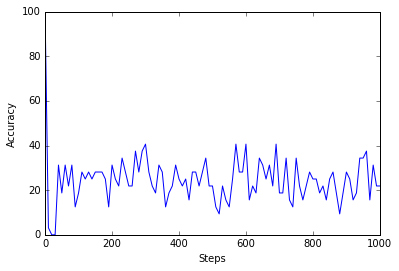

In [14]:
print graphy
plt.plot(graphx,graphy)
plt.ylabel('Accuracy')
plt.xlabel('Steps')
plt.show()

In [15]:
test_accuracy = accuracy.eval(feed_dict={x: testset.images, y: testset.labels, keep_prob: 1.0}, session=sess)
print 'test accuracy %g' % test_accuracy

test accuracy 0.242424


In [16]:
saver = tf.train.Saver()
saver.save(sess, "saved models/model"+str(n_classes)+".ckpt")

'saved models/model5.ckpt'